<font color = brown size =10 >   
ASIM AWAD HUSSEIN OSMAN
</font>


> In this work I managed to train a vehicle Re-identification model on the VeRi dataset using triplet loss.



> I mined treplet using two methods and trained two model, one for each method,

> The semi hard triplet mining outperforms the random triplet mining both in training time and accuray or results

> I measured the performance using mAP and visual inspection. my best performing model scored() on the mAP.

# <font color = brown size =8 >   Imports </font>


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
from collections import defaultdict
import time
import PIL
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Sampler
from torchvision import transforms, models
from PIL import Image
import os
import xml.etree.ElementTree as ET

In [ ]:
from google.colab import drive
drive.mount('/content/Asim')

Mounted at /content/Asim


In [ ]:
! unzip /content/Asim/MyDrive/VeRi.zip -d VeRi

Streaming output truncated to the last 5000 lines.
  inflating: VeRi/VeRi/image_train/0665_c012_00062320_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c012_00062325_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c013_00062110_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c013_00062115_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c013_00062120_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c013_00062125_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c013_00062130_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c013_00062135_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c014_00063935_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c014_00063940_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c014_00063945_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c014_00063950_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c014_00063955_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c014_00063960_0.jpg  
  inflating: VeRi/VeRi/image_train/0665_c015_00063745_0.jpg  
  inflating: VeRi/V

# <font color = brown size =8 >  Data Processing and Creating a Custom DataSet   </font>

This is the most Important Section, I done many steps as follows:



> **Extract annotations for Train, Query and Test Data:**  I used the Train_label.xml and test_label.xml and the names of the query images to extract two useful datastructures, the first one is the annotations, which is mapping between every image and its label, the other one is grouped annotations which maps every unique label with the paths of the images that belong to this label(vehicle Id) and I alsoo created a list of the uniqe Ids to sample the triplets anchors from later.


> **Create custom datasets** to ease the manipualtion and creation of triplets for training data, and preparing the query and test data for evaluation. these datasets produce tuples where each tuple is (image_tensor,label) as a first step more processing will be done on the training data later



> **Preparing the feature extraction Model** : I used a Resnet as my base model using a last layer of 256 dim as my embedding layer.





## <font color = blue size = 5 > 1. Creating Annotations  </font>

In [ ]:
#  parse the xml files and get the annotations
def get_grouped_annotations(path):
  with open(path,'r') as f:
      root = ET.fromstring(f.read())
      images_root  = root[0]
  annotations = {}
  with open(path,'r') as f:
      root = ET.fromstring(f.read())
      images_root  = root[0]
  for image in images_root:
    attributes =  dict(itertools.islice( image.attrib.items(), 2))
    imageName  =  attributes['imageName']
    id         =  attributes['vehicleID']
    if id not in annotations :
        annotations[id] = []
    annotations[id].append(imageName)

  return annotations
#  this looks like this [ {image : label} , {image: label } , ..... ]
def get_annotations(path):
  annotations = []
  with open(path,'r') as f:
      root = ET.fromstring(f.read())
      images_root  = root[0]
  for image in images_root:
     annotations.append( dict(itertools.islice( image.attrib.items(), 2)))

  return annotations
def get_query_labels(quey_path):
  for _ , _ ,paths in os.walk(quey_path):
    query_labels = [image_name.split("_")[0] for image_name in paths ]
    return paths, query_labels

In [ ]:
quey_path = '/content/VeRi/VeRi/image_query'


query_names, query_labels = get_query_labels(quey_path)
train_annotations = get_annotations('/content/VeRi/VeRi/train_label.xml')
test_annotations  = get_annotations('/content/VeRi/VeRi/test_label.xml')


# examples:
len(train_annotations) , train_annotations[:5]

(37746,
 [{'imageName': '0001_c001_00016450_0.jpg', 'vehicleID': '0001'},
  {'imageName': '0001_c001_00016460_0.jpg', 'vehicleID': '0001'},
  {'imageName': '0001_c001_00016470_0.jpg', 'vehicleID': '0001'},
  {'imageName': '0001_c001_00016480_0.jpg', 'vehicleID': '0001'},
  {'imageName': '0001_c001_00016490_0.jpg', 'vehicleID': '0001'}])

## <font color = blue size = 5 >  2. Creating Custom Datasets   </font>

In [ ]:
# Preparing The Dataset FOR TRAINING AND TEST DATA & query data

# Custom Dataset Class
class VeRi(Dataset):
    def __init__(self, image_folder_path, annotations= None, transform=None, query = False , labels = None, query_names = None):
        self.image_folder = image_folder_path
        self.annotations = annotations
        self.transform = transform
        self.labels = labels
        self.query = query
        self.query_names = query_names

    def __len__(self):
      if self.query:
        return len(self.query_names)
      else:
        return len(self.annotations)

    def __getitem__(self, idx):
      if self.query:
        # vehicle_ids = list(self.annotations.keys())
        img_name = os.path.join(self.image_folder, self.query_names[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]
        image = self.transform(image) if self.transform else image
        return image, torch.tensor(int(label))
      else:
        # vehicle_ids = list(self.annotations.keys())
        img_name = os.path.join(self.image_folder, self.annotations[idx]['imageName'])
        image = Image.open(img_name).convert('RGB')
        label = self.annotations[idx]['vehicleID']
        image = self.transform(image) if self.transform else image
        return image, torch.tensor(int(label))



# create dataset
# transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])




> Here I created the actual dataset, tensors with their labels, for the training set, more data processing will be done according to triplet mining technique I will use



In [ ]:
train_path = '/content/VeRi/VeRi/image_train'
quey_path = '/content/VeRi/VeRi/image_query'
test_path = '/content/VeRi/VeRi/image_test'
# create dataset
train_dataset = VeRi(train_path, train_annotations, transform=data_transforms)
test_dataset = VeRi(test_path, test_annotations, transform=data_transforms)
query_dataset = VeRi(image_folder_path = quey_path,annotations=None, transform=data_transforms , query = True , labels= query_labels,query_names= query_names)


## <font color = blue size = 5 >  Preparing The Base Model (ResNet):   </font>

> My choice for this model is for it good track record for performing on any task, I manipulated the last fully connected layer to be of dimention 256 as the final embedding of the pictures.



In [ ]:
class EmbeddingNetwork(nn.Module):
    def __init__(self, dim=256):
        super(EmbeddingNetwork, self).__init__()
        # loading a pretrained resnet model and get rid of the fiinal layer
        self.base_model = models.resnet50(pretrained=True)
        self.base_model.fc =  nn.Linear(self.base_model.fc.in_features, dim) # adding our embedding layer

    def forward(self, x):
        x = self.base_model(x) # feature extraction
        return x

# <font color = brown size =8 >  Method 1 : Model with random offline treplets generation </font>

In this model I trained The resnet using trplet loss and 10,000 randomly sampled triplets from the entire dataset,

> Prepared 37,000 triplets from the dataset, as every image takes turns as an anchor, then randomly chose 10,000 from them for training.

>  The model was trained for 10 epochs. training took multiple hours, done on Kaggle platform and saved the model parameters localy to evaluate it here.









##  <font color = blue size = 5 > Creating Offline Triplets </font>

this was done in twoe steps:

1.   First: I used the train annotation data structurre to create a dictionary
     containing each vehcle id with the indices of the images that belong to this id. These indices are the same in the annotation datastructure and in the train dataset created earlear.


2.  Using this dictinary, I collected 37,000 triplets in the form of indices
     (anchor_image_idx , positive_img_idx , negative_img_idx)



3.   Then I randomly sampled 10,000 from these triplets of indices


4.  The next step was to create another small dataset class that takes the old dataset, and at each given index, gives the triplets in the form of tensors and labels

4.  The Last step was to create a dataloader that creates batches of 32 or 64 triplets every time,


In [ ]:
def offline_treplets(annotations):
    triplets = []
# images by vehicle ID
    vehicle_id_to_images = {}
    for idx, item in enumerate(annotations):
        vehicle_id = item['vehicleID']
        if vehicle_id not in vehicle_id_to_images:
            vehicle_id_to_images[vehicle_id] = []
        vehicle_id_to_images[vehicle_id].append(idx)

    vehicle_ids = list(vehicle_id_to_images.keys())

    anchor_id = 0
    for anchor_idx in range(len(annotations)):
        # the anchor vehicle
        anchor_vehicle_id = annotations[anchor_idx]["vehicleID"]
#   to point at the next datapoint
        anchor_indices = vehicle_id_to_images[anchor_vehicle_id]
        anchor_idx = anchor_idx
        positive_idx = random.choice(anchor_indices)

#  if the anchor and the pos are the same
        while positive_idx == anchor_idx:
            positive_idx = random.choice(anchor_indices)

          #find a random negative
        negative_vehicle_id = random.choice(vehicle_ids)
        while negative_vehicle_id == anchor_vehicle_id:
            negative_vehicle_id = random.choice(vehicle_ids)
        negative_idx = random.choice(vehicle_id_to_images[negative_vehicle_id])

        triplets.append((anchor_idx, positive_idx, negative_idx))

    return triplets

# now the triplet creation dataset
class Offline_treplets_ds(Dataset):
    def __init__(self, dataset, triplets):
        self.dataset = dataset
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor_idx, positive_idx, negative_idx = self.triplets[idx]
        A, _ = self.dataset[anchor_idx]
        P, _ = self.dataset[positive_idx]
        N, _ = self.dataset[negative_idx]

        return A, P, N
# num_triplets = 10000
triplets = offline_treplets(train_annotations)
mini_triplets = random.sample(triplets, 10000)

In [ ]:
 #dataset for triplet training
triplet_train_dataset = Offline_treplets_ds(train_dataset, triplets)

# Create a DataLoader for the triplet dataset
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=64, shuffle=True)

In [ ]:
data = next(iter(triplet_train_loader))

mini_triplets[:10],data[2].shape

([(29224, 29252, 24567),
  (8258, 8211, 23792),
  (24776, 24807, 12603),
  (21552, 21542, 30729),
  (15869, 15863, 7396),
  (27239, 27323, 6429),
  (19228, 19193, 4272),
  (34045, 34069, 33996),
  (22916, 22915, 26304),
  (28806, 28842, 25241)],
 torch.Size([64, 3, 224, 224]))

##  <font color = blue size = 5 > Model training </font>

Prepared the loss function , trained for 10 epochs on kaggle and saved the chechpoint, I will include the training log in a cell, then load the model from google drive to evaluate its performance

In [ ]:
#
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Offline_model = EmbeddingNetwork(dim=256)
Offline_model = Offline_model.to(device)
# Instantiate the triplet loss
triplet_loss_fn = TripletLoss(margin=0.3)
optimizer = optim.Adam(Offline_model.parameters(), lr=1e-4)

# Training loop
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (anchors, positives, negatives) in enumerate(dataloader):
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)

        # Forward pass
        anchor_embeddings = model(anchors)
        positive_embeddings = model(positives)
        negative_embeddings = model(negatives)

        # Compute the triplet loss
        loss = loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Training Loss: {running_loss/len(dataloader)}')




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


In [ ]:
for epoch in range(10):  # Train for 10 epochs
    train_epoch(Offline_model, triplet_train_loader, optimizer, triplet_loss_fn, device)


# Training log from Kaggle:

# EPOCH {1/10}avg Training Loss: 0.03507483413411399
# EPOCH {2/10}avg Training Loss: 0.01477037967198481
# EPOCH {3/10}avg Training Loss: 0.011243245886417768
# EPOCH {4/10}avg Training Loss: 0.012354465162034258
# EPOCH {5/10}avg Training Loss: 0.008034710871781838
# EPOCH {6/10}avg Training Loss: 0.005773327951082739
# EPOCH {7/10}avg Training Loss: 0.009455318597413725
# EPOCH {8/10}avg Training Loss: 0.006001427283478996
# EPOCH {9/10}avg Training Loss: 0.00508460846050816
# EPOCH {10/10}avg Training Loss: 0.003146303110456062

In [ ]:
#  Loading the model checkpoint from drive 'model.pt'
Offline_model.load_state_dict(torch.load("/content/model/model.pt"))
Offline_model.eval()                                    # set the model to evaluation mode
Offline_model.to(device)                                    # gpu

# <font color = brown size =8 >  Method 2. Online Triblet Mining </font>


**In this trial my work consist of two main big steps:**



1.   **The First Step** is to prepare the data to go to the model in batches that have certain properties(from the lecture), specifically each batch should consist of P identities and k images for each identities
2.   **The Second Step** is to train models with different configurations of P annd k , I trained two models One with P = 4 and k = 4 , and another one with P = 8 and k = 4. and saved the models checkpoing to avoid redundancy in code




##  <font color = blue size = 5 > Step 1. Mini batch preperation and treplet mining implementation (from lecture) </font>

- **Data Organization:**
  - Grouped images by vehicle ID into `grouped_annotations` for easy access.
  - Created `vehicle_id_to_images`, mapping each vehicle ID to indices in `train_dataset`.

- **Custom PK Sampling:**
  - Implemented a custom sampler (`PKSampler`) to sample `P` identities with `K` images per identity, a mini-batch of size (P * K).

- **DataLoader Setup:**
  - Configured a `DataLoader` with the custom sampler to generate mini-batches suitable for triplet mining.

- **Semi-Hard Triplet Mining:**
  - Calculated pairwise distances and selected semi-hard negatives that satisfy $$ D_{\text{ap}} < D_{\text{an}} < D_{\text{ap}} + \text{margin}$$.
  - Used hardest negative as a fallback if no semi-hard negatives were found.



In [ ]:

# grouped_annotations : each vehcle id wiht all image names having that id
grouped_annotations = get_grouped_annotations('/content/VeRi/VeRi/train_label.xml')#  k should be 11, p shoul be 4
# vehicle_id_to_images :same as the above but this has indices of the images that are going to be retrived from train_dataset
vehicle_id_to_images = {}

for idx, item in enumerate(train_annotations):
    vehicle_id = item['vehicleID']
    if vehicle_id not in vehicle_id_to_images:
        vehicle_id_to_images[vehicle_id] = []
    vehicle_id_to_images[vehicle_id].append(idx)

identities = list(vehicle_id_to_images.keys())


#  THE SAMPLER : this is a manipulation of the dataloader in pyTorch, it simply gives you a batch with p identities and k samples each
class PKSampler(Sampler):
    def __init__(self, vehicle_id_to_images, identities, P, K):
        self.vehicle_id_to_images = vehicle_id_to_images
        self.identities = identities
        self.P = P
        self.K = K

    def __iter__(self):
        while True:
            # Sample P identities (classes)
            sampled_identities = random.sample(self.identities, self.P)

            # For each identity, sample K images
            mini_batch = []
            for cls in sampled_identities:
                all_images = self.vehicle_id_to_images[cls]
                sampled_images = random.sample(all_images, self.K)
                mini_batch.extend(sampled_images)

            yield mini_batch

    def __len__(self):
        return len(self.identities) // self.P

P = 4
K = 4
sampler = PKSampler(vehicle_id_to_images, identities, P, K)

#create the dataLoader using the custom sampler
train_loader = DataLoader(train_dataset, batch_sampler=sampler, num_workers=2)

In [ ]:
# the code here is inspired from https://omoindrot.github.io/triplet-loss#offline-and-online-triplet-mining

def semi_hard_triplet_mining(embeddings, labels, margin=1.0):
    # the first thing is to find the pairwise distances in a 2d matrix
    pairwise_dist = torch.cdist(embeddings, embeddings)
    batch_size = embeddings.shape[0]
    anchor_idx, positive_idx, negative_idx = [], [], []

    for i in range(batch_size):
          # we will create a triplet for every datapoint in this batch
        anchor_label = labels[i]

 # filter the row corresponding to the first chosen anchore with their labels
        positive_mask = (labels == anchor_label).float()
        positive_mask[i] = 0                                        # remove the anchor itself


        #select negative examples by filtering the ssame row and keep where the labels dont match the anchor's label
        negative_mask = (labels != anchor_label).float()

        # Find semi-hard negatives: farther than positive but within a margin
        # get the distances filtered
        pos_dist = pairwise_dist[i] * positive_mask
        neg_dist = pairwise_dist[i] * negative_mask

        # Select a positive example randomly from available positives
        positive_idx_i = torch.argmax(pos_dist)
        positive_distance = pairwise_dist[i][positive_idx_i]

        # Select a negative example that satisfies semi-hard condition
        semi_hard_mask = (neg_dist > positive_distance).float() * (neg_dist < (positive_distance + margin)).float()
        if semi_hard_mask.sum() > 0:
            negative_idx_i = torch.argmax(semi_hard_mask * neg_dist)
        else:
            # If no semi-hard negatives are found, fall back to the hardest negative
            negative_idx_i = torch.argmin(neg_dist + (1 - negative_mask) * 1e6)

        # Save the triplet indices
        anchor_idx.append(i)
        positive_idx.append(positive_idx_i.item())
        negative_idx.append(negative_idx_i.item())

    # Select the embeddings based on the triplet indices
    anchors = embeddings[anchor_idx]
    positives = embeddings[positive_idx]
    negatives = embeddings[negative_idx]

    return anchors, positives, negatives


##  <font color = blue size = 5 > Step 2. Model Training </font>

I trained Two modes, the first one with p= 4 , k =4 trained for 20 Epochs, saved locally for later Evaluation, the other one,P = 8, k = 4 and 50 Epochs.

**NOTE** : Since the data loader saples data each time from the entire dataset, I had to put a limit on the no. of batches, becase the dataloader could sample forever and the epoch would not end, my limit in the first model was 115, in the second bigger model my limit was 300 batch, which means approximatly 300 * 32 triplets that the model trains on.

In [ ]:
# implement the treplet loss, standard in pyTorch
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        loss = loss.mean()
        return loss
device = 'cuda' if torch.cuda.is_available() else 'cpu'
online_model = EmbeddingNetwork(dim=256)
online_model = online_model.to(device)

triplet_loss_fn = TripletLoss()
optimizer = optim.Adam(online_model.parameters(), lr=1e-4)

# Training loop example
def train_triplet_network(model, train_loader, optimizer, margin=1.0, device='cuda'):
    model.train()
    total_loss = 0
    batch_limit = 300 #because th data loader samples from the entire dataset with no limit
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # find the embeddings for the 32 images in the batch
        embeddings = model(images)

        # get the processsed semi hard anchors, positive and negatives
        anchors, positives, negatives =  semi_hard_triplet_mining(embeddings, labels)


        # calculate triplet loss
        loss = triplet_loss_fn(anchors, positives, negatives)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        # print(batch_idx)
        if batch_idx == batch_limit:
          break
        elif  batch_idx % 100 == 0  :
          print(f'Batch [{batch_idx+1}/{batch_limit}], Loss: {loss.item():.4f}')



    avg_loss = total_loss / batch_limit
    return avg_loss



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 57.0MB/s]


In [ ]:
num_epochs = 50
save_model = '/content/Asim/MyDrive/semi_hard_vehicle_reid_model2.pth'   # Define save path

for EPOCH in range(num_epochs) :
  avg_loss = train_triplet_network(online_model, train_loader, optimizer, margin=1.0, device=device)
  print(f"Epoch [{EPOCH+1}/{num_epochs}], Loss: {avg_loss:.4f}")


  # Save the model
  torch.save(online_model.state_dict(), save_model)

Batch [1/300], Loss: 0.5977
Batch [101/300], Loss: 0.3557
Batch [201/300], Loss: 0.4705
Epoch [1/50], Loss: 0.6538
Batch [1/300], Loss: 0.5068
Batch [101/300], Loss: 1.0755
Batch [201/300], Loss: 0.3014
Epoch [2/50], Loss: 0.5276
Batch [1/300], Loss: 0.4329
Batch [101/300], Loss: 0.6086
Batch [201/300], Loss: 0.3981
Epoch [3/50], Loss: 0.4215
Batch [1/300], Loss: 0.7355
Batch [101/300], Loss: 0.0000
Batch [201/300], Loss: 0.0485
Epoch [4/50], Loss: 0.3667
Batch [1/300], Loss: 0.2283
Batch [101/300], Loss: 0.2585
Batch [201/300], Loss: 0.1099
Epoch [5/50], Loss: 0.3501
Batch [1/300], Loss: 0.7919
Batch [101/300], Loss: 0.3297
Batch [201/300], Loss: 0.9016
Epoch [6/50], Loss: 0.3275
Batch [1/300], Loss: 0.0000
Batch [101/300], Loss: 0.1394
Batch [201/300], Loss: 0.0530
Epoch [7/50], Loss: 0.2744
Batch [1/300], Loss: 0.5839
Batch [101/300], Loss: 0.1009
Batch [201/300], Loss: 0.8198
Epoch [8/50], Loss: 0.2971
Batch [1/300], Loss: 0.2706
Batch [101/300], Loss: 0.3124
Batch [201/300], Loss:

# <font color = brown size =8 >  Evaluation </font>


In this section, I first implement functions that will help us evaluate the model, both quantitativly and qualitativly, these functions are :


1-  **Extract features**, takes the query and test images and turns them into embedding using a trained model.


2- **Compute average precision** : calculates the average precision for a single query.

3- **visualize ranking**, this is for the qualitativ evaluation , takes a query and shows the to k retrival or (identifications from the test set)


Then I evaluate each of my three models with visual Example

##  <font color = blue size = 5 > Functions </font>


In [ ]:
def extract_features(dataloader, model, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            labels.extend(lbls.numpy())
            # I turned them to numpy because the distance calculation function from sklearn needs them in this shape

    # this is to concatenate all the features and labels
    features = np.concatenate(features, axis=0)
    labels = np.array(labels)
    return features, labels

def compute_average_precision(query_label, ranking):
    # get the number of true positives
    No_true_positives = 0
    precision_sum = 0
# no calc the precesion at every point (rank)
    for i, label in enumerate(ranking):
        if label == query_label:
            No_true_positives += 1
            precision_ = No_true_positives / (i + 1) # this calculates the average presision at that location
            precision_sum += precision_

    #  average precision for the query
    if No_true_positives == 0:
        return 0
    return precision_sum / No_true_positives


def visualize(query_index, rankings, query_names, test_annotations, top_k=5):
    # Get the file path for the query image and top ranked test images
    query_image_path = os.path.join('/content/VeRi/VeRi/image_query', query_names[query_index])
    query_label = query_names[query_index].split("_")[0]
    ranked_test_images = [[os.path.join('/content/VeRi/VeRi/image_test', test_annotations[idx]['imageName']) , test_annotations[idx]['vehicleID']]
                          for idx in rankings[query_index][:top_k]]
    query_image = Image.open(query_image_path).convert("RGB")
    #display the top  ranked test pictures
    fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 9))
    fig.suptitle(f"Query Image and Top {top_k} Ranked Results", fontsize=16)

    #the query image and the ranked image
    axes[0].imshow(query_image)
    axes[0].set_title(f"Query : {query_label}")
    axes[0].axis("off")
    for i, (test_image_path,label) in enumerate(ranked_test_images):
        test_image = Image.open(test_image_path).convert("RGB")
        axes[i + 1].imshow(test_image)
        axes[i + 1].set_title(f"Rank {i + 1}: {label}")
        axes[i + 1].axis("off")
    plt.show()


# Create dataLoader for query and test images
query_loader = DataLoader(query_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


##  <font color = blue size = 5 > Evaluation Of Individual Models </font>


### Model 1 : 10,000 offline treplets Model

In [ ]:
! unzip /content/Asim/MyDrive/VeReId_models/Vehicle_Re_Id10000t.zip

Archive:  /content/Asim/MyDrive/VeReId_models/Vehicle_Re_Id10000t.zip
  inflating: model/model.pt          


In [ ]:
#  load the model

#  Loading the model checkpoint from drive 'model.pt'
Offline_model.load_state_dict(torch.load("/content/model/model.pt"))
Offline_model.eval()                                    # set the model to evaluation mode
Offline_model.to(device)

<ipython-input-22-a20f7551bd3b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Offline_model.load_state_dict(torch.load("/content/model/model.pt"))


EmbeddingNetwork(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Extract features for both datasets query and test - turn them to embeddings
query_features, query_labels = extract_features(query_loader, Offline_model, device)
test_features, test_labels = extract_features(test_loader, Offline_model, device)


# Calculate pairwise Euclidean distances between query and test features
distances = euclidean_distances(query_features, test_features)

# Get the indices of the sorted distances
rankings = np.argsort(distances, axis=1)

rankings

array([[ 7209,  7210,  7212, ...,  3366,  3365,  3368],
       [ 1091,  1092,  1090, ...,  3366,  3365,  3368],
       [10186, 10652, 10803, ...,  3366,  3365,  3368],
       ...,
       [ 6157,  6158,  5964, ...,  3366,  3365,  3368],
       [ 7307,  6569,  6566, ...,  3366,  3365,  3368],
       [ 4365,  5253,  5255, ...,  3366,  3365,  3368]])

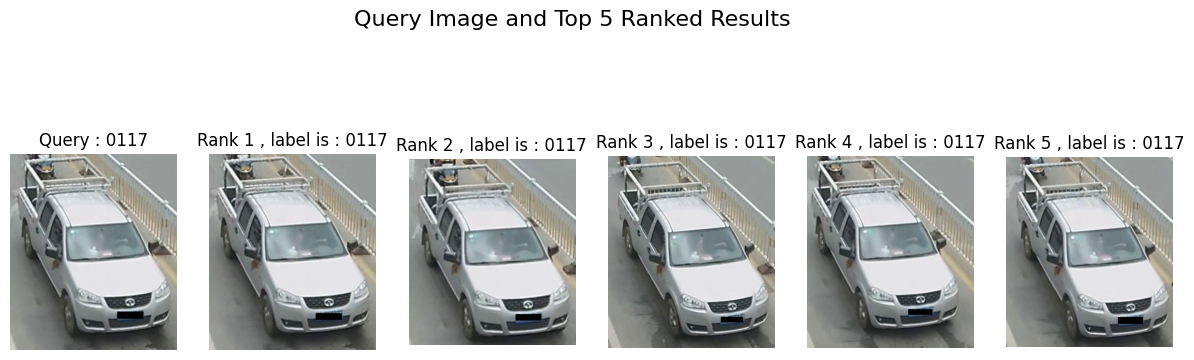

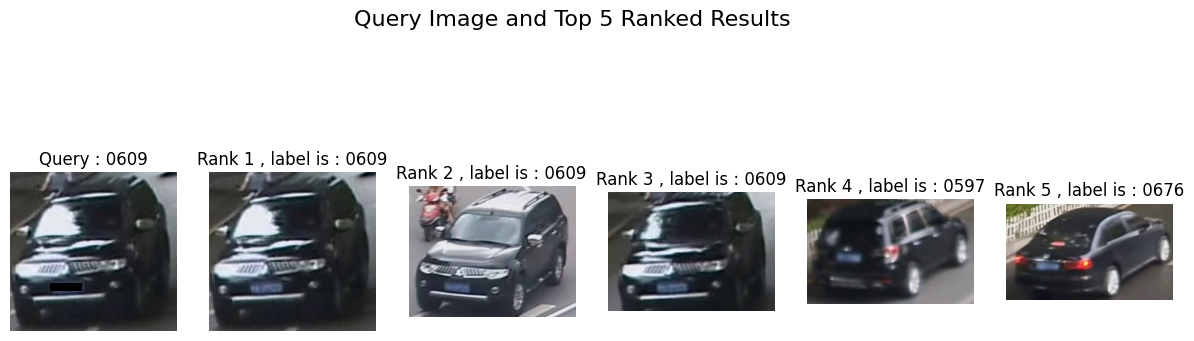

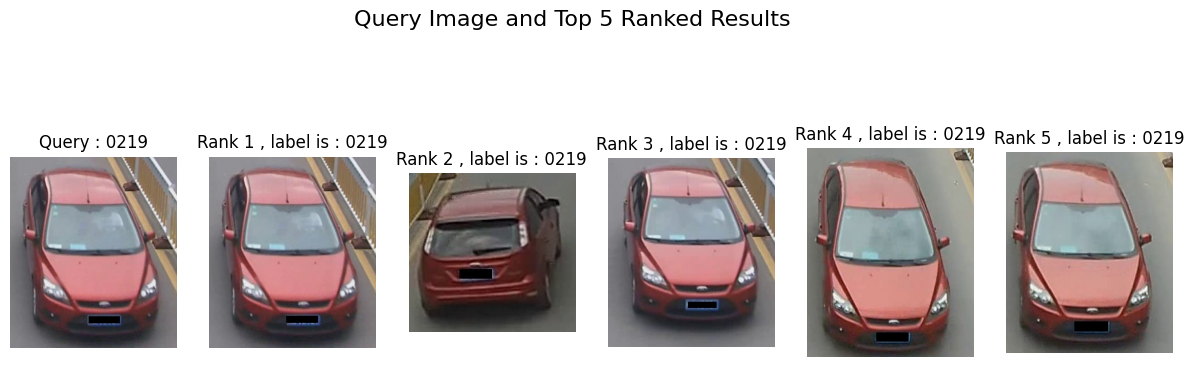

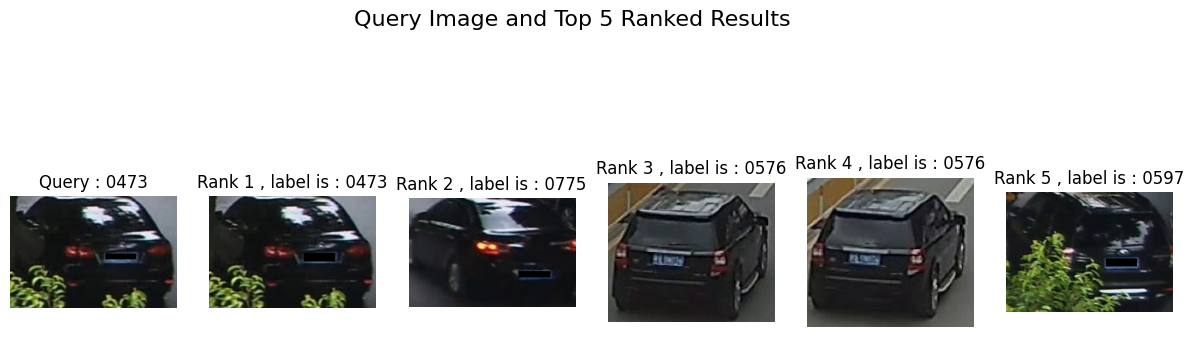

In [ ]:
#  Now the Qualitative evaluation,
visualize(query_index=80, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=5)
visualize(query_index=41, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=5)
visualize(query_index=787, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=5)
visualize(query_index=601, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=5)


In [ ]:
#  NOTICE THAT THE MODEL DOES A GOOD JOB ON EASY EXAMPLES AND PERFORMS POOR ON THE ONES THAT ARE A BIT TRIKY

In [ ]:
# Calculate mean Average Precision (mAP) for all the query images
average_precisions = []
for i in range(len(query_labels)):
    ranked_labels = test_labels[rankings[i]]
    ap = compute_average_precision(query_labels[i], ranked_labels)
    average_precisions.append(ap)
mean_average_precision = np.mean(average_precisions)
print(f'Mean Average Precision (mAP): {mean_average_precision:.4f}')


Mean Average Precision (mAP): 0.1733




> #### <font color = blue size = 3> Comment </font>


**For a randomly sampled triplet mining strategy, the model captures some semantic similarities , but indicates poor sampling strategy as the model doesn't have hich accuracy with an mAP of only 0.17**



### Model 2 : Semi Hard Mining Model with P = 4 , k = 4 and trained for 20 Epochs

In [ ]:

#  Loading the model checkpoint from drive 'semi_hard_vehicle_reid_model.ptH'
online_model.load_state_dict(torch.load("/content/Asim/MyDrive/VeReId_models/semi_hard_vehicle_reid_model.pth"))
online_model.eval()                                    # set the model to evaluation mode
online_model.to(device)

<ipython-input-43-3ab8da29ef5f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  online_model.load_state_dict(torch.load("/content/Asim/MyDrive/VeReId_models/semi_hard_vehic

EmbeddingNetwork(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Extract features for both datasets query and test - turn them to embeddings
query_features, query_labels = extract_features(query_loader, online_model, device)
test_features, test_labels = extract_features(test_loader, online_model, device)


# Calculate pairwise Euclidean distances between query and test features
distances = euclidean_distances(query_features, test_features)

# Get the indices of the sorted distances
rankings = np.argsort(distances, axis=1)

rankings

array([[ 7209,  7211,  7210, ...,  2508,  3857,  3856],
       [ 1091,  1090,  1089, ...,  3857,  2945,  3856],
       [10186, 10156,  9533, ...,  2529,  2507,  2508],
       ...,
       [ 6157,  6159,  6158, ...,  3857,  3861,  3856],
       [ 7307,  7309,  7534, ...,  2507,  3856,  2508],
       [ 4365,  4954,  5014, ...,  3860,  3861,  3856]])

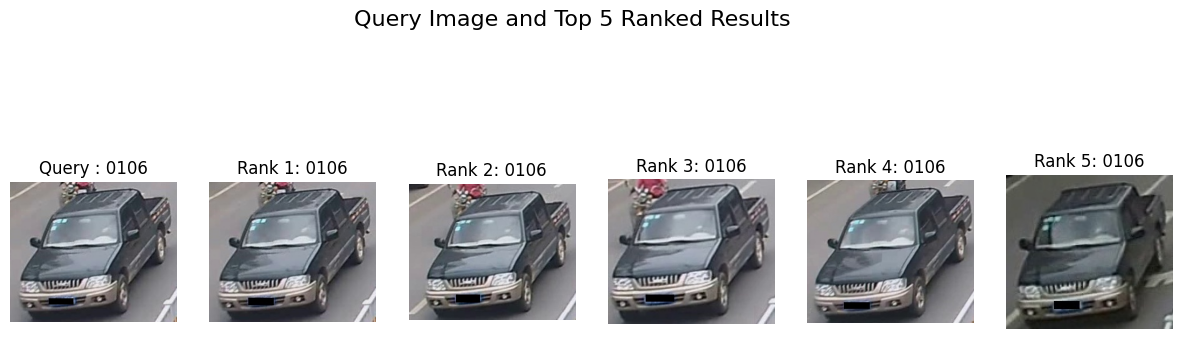

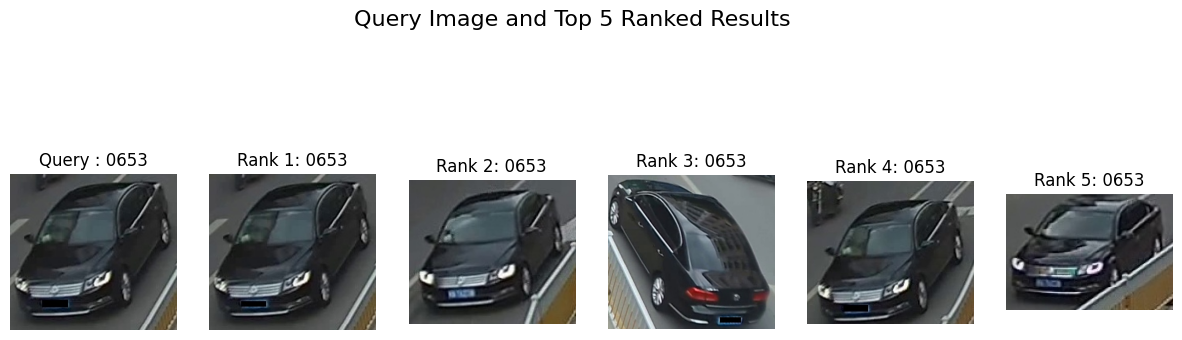

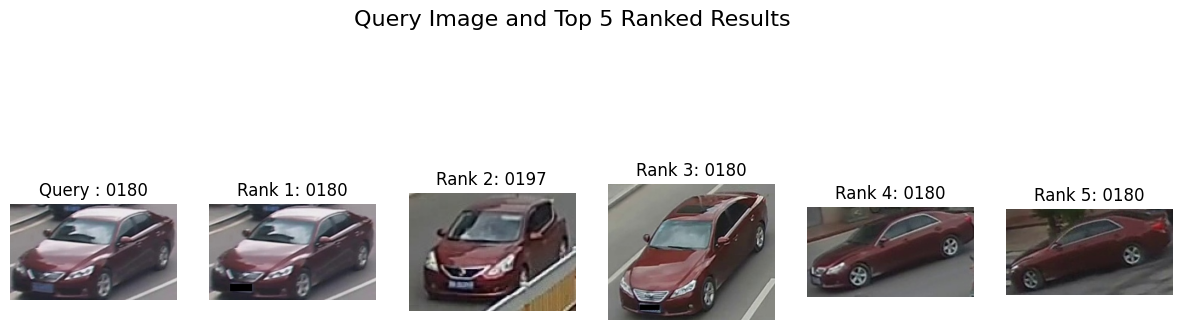

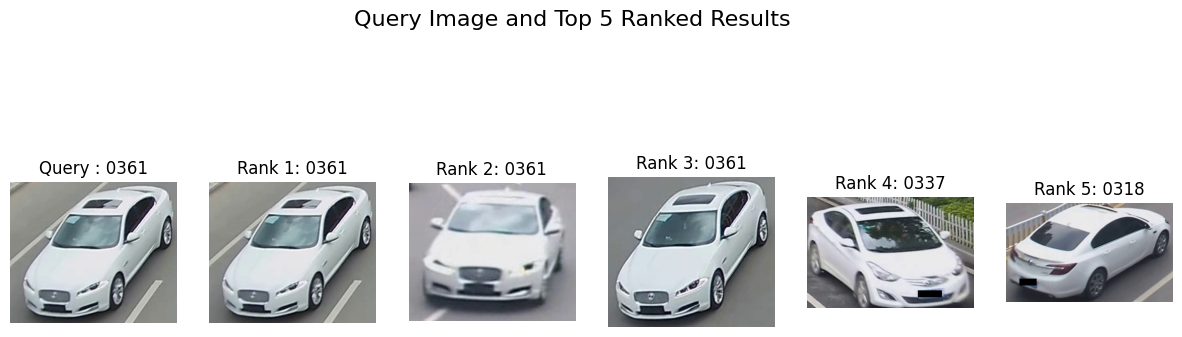

In [ ]:
#  Now the Qualitative evaluation,
visualize(query_index=1, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=5)
visualize(query_index=100, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=5)
visualize(query_index=200, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=5)
visualize(query_index=300, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=5)


In [ ]:
#  THE MODEL DOES BETTER JOB AT DISTINGUISHING THE CARS THAT LOOKS SIMILAR, NOW LETS LOOK AT THE MAP

In [ ]:
# Calculate mean Average Precision (mAP) for all the query images
average_precisions = []
for i in range(len(query_labels)):
    ranked_labels = test_labels[rankings[i]]
    ap = compute_average_precision(query_labels[i], ranked_labels)
    average_precisions.append(ap)
mean_average_precision = np.mean(average_precisions)
print(f'Mean Average Precision (mAP): {mean_average_precision:.4f}')


Mean Average Precision (mAP): 0.3621




>#### <font color = blue size = 3> Comment </font>



**The semi hard mining strategy worked better than the random one, indicating that few informative triplets are much better that 10,000 random triplets, the model does better job in differentiating betweent similar vehiclesand gives a lot better score in terms of an mAP of 0.36**

### Model 3 : BIGGER Semi Hard Mining Model with P = 8 , k = 4 and trained for 50 Epochs

In [ ]:
#  Loading the model checkpoint from drive 'semi_hard_vehicle_reid_model.ptH'
online_model.load_state_dict(torch.load("/content/semi_hard_vehicle_reid_model2.pth"))
online_model.eval()                                    # set the model to evaluation mode
online_model.to(device)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# Extract features for both datasets query and test - turn them to embeddings
query_features, query_labels = extract_features(query_loader, online_model, device)
test_features, test_labels = extract_features(test_loader, online_model, device)


# Calculate pairwise Euclidean distances between query and test features
distances = euclidean_distances(query_features, test_features)

# Get the indices of the sorted distances
rankings = np.argsort(distances, axis=1)

rankings

array([[ 7209,  7210,  7208, ..., 10340,  8824, 10341],
       [ 1091,  1092,  1090, ...,  5139,  5167,  5163],
       [10186, 10185, 10155, ...,  6644,  6710,  6699],
       ...,
       [ 6157,  6161,  6158, ...,  5121,  5167,  5163],
       [ 7307,  7218,  7306, ..., 10339, 10340, 10341],
       [ 4365,  4955,  4367, ..., 11003, 10340, 10341]])

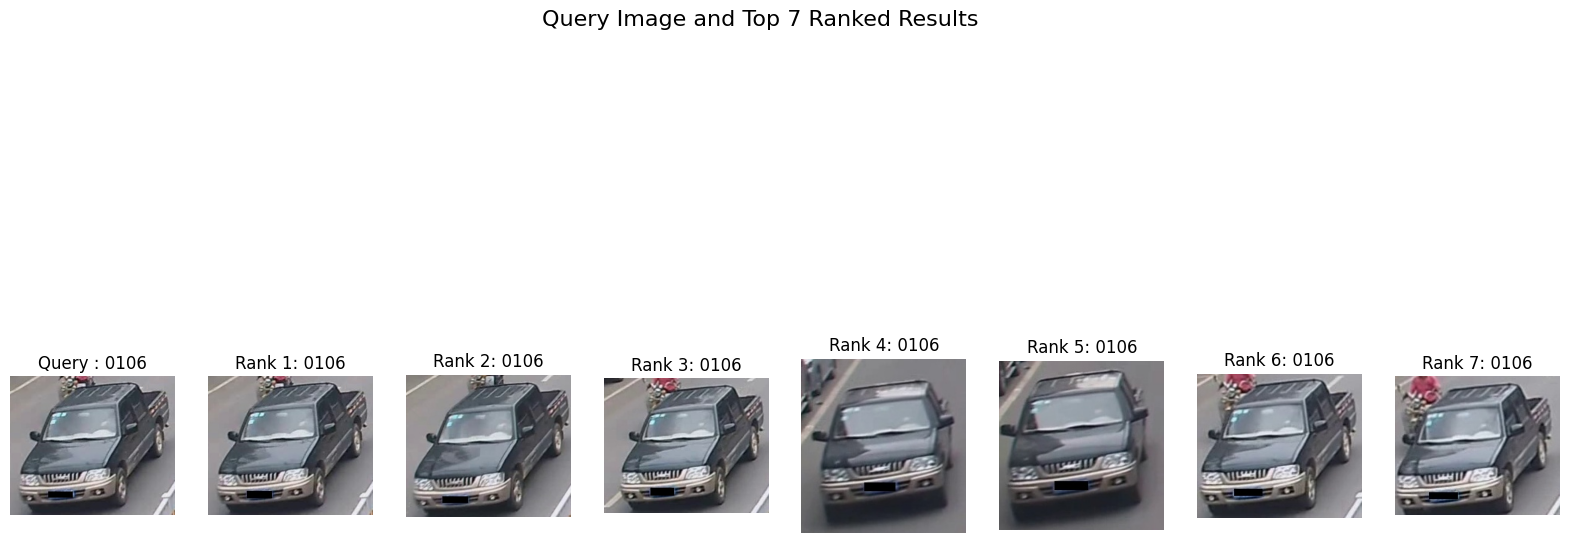

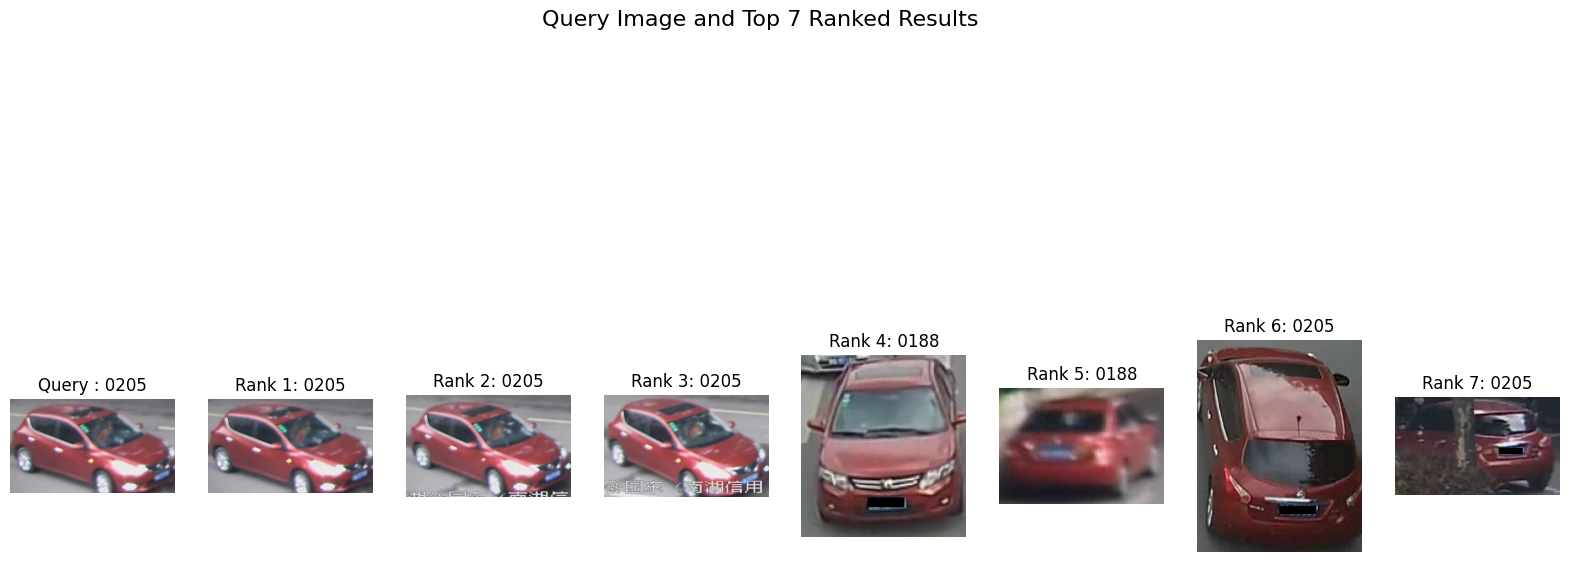

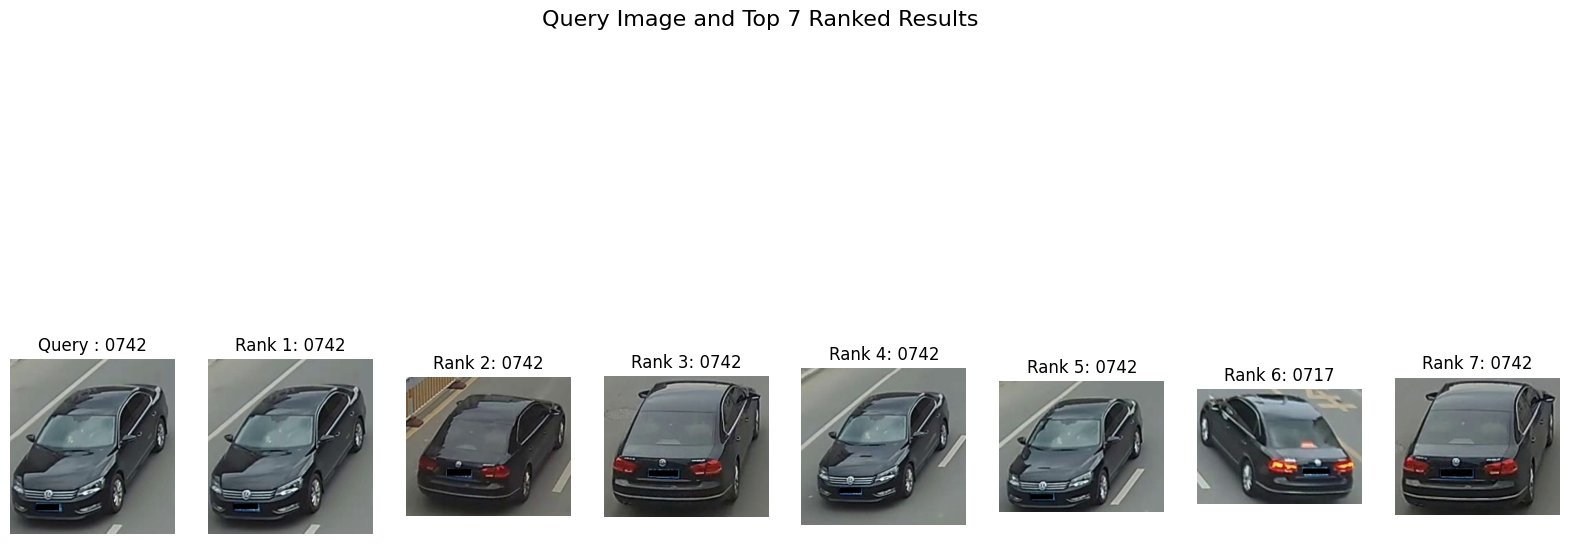

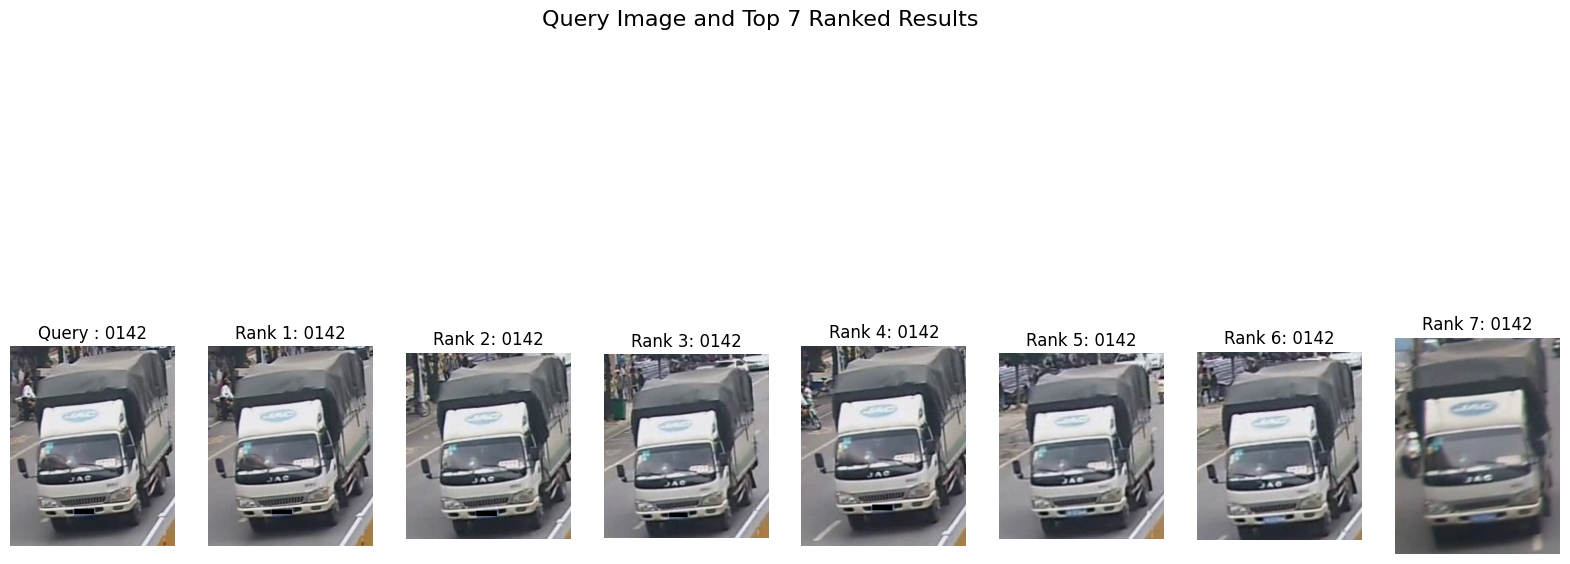

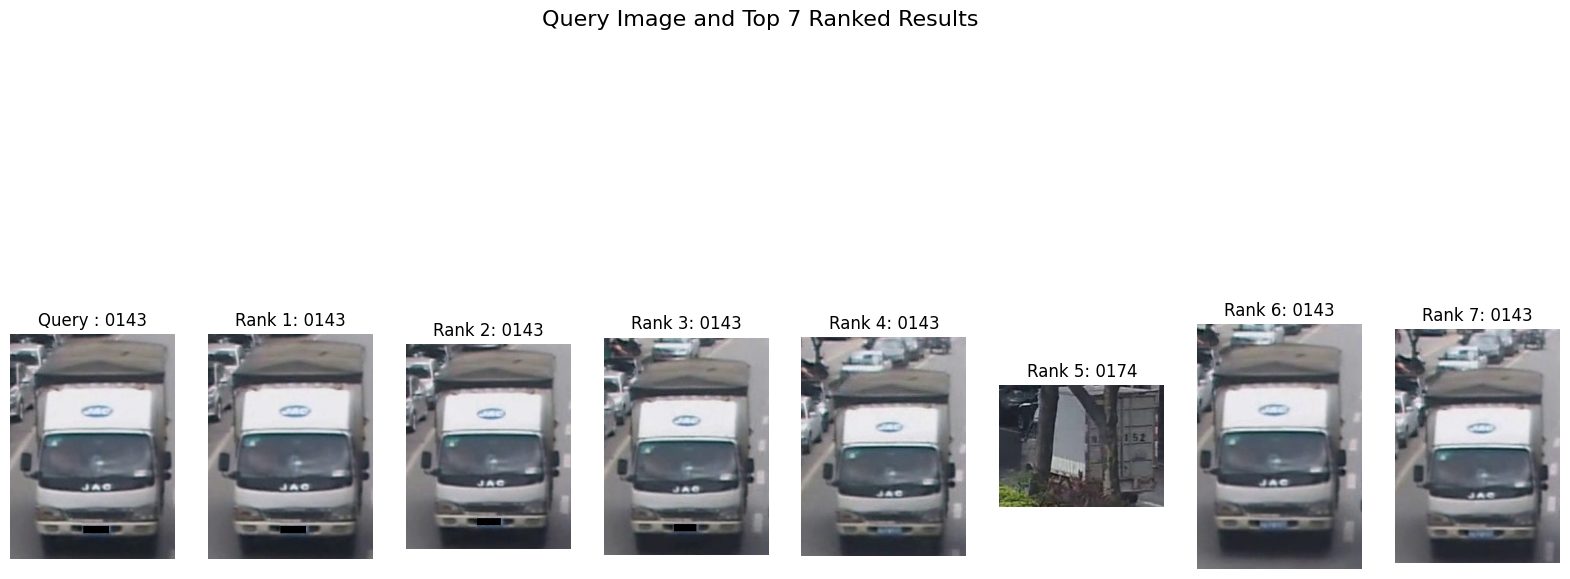

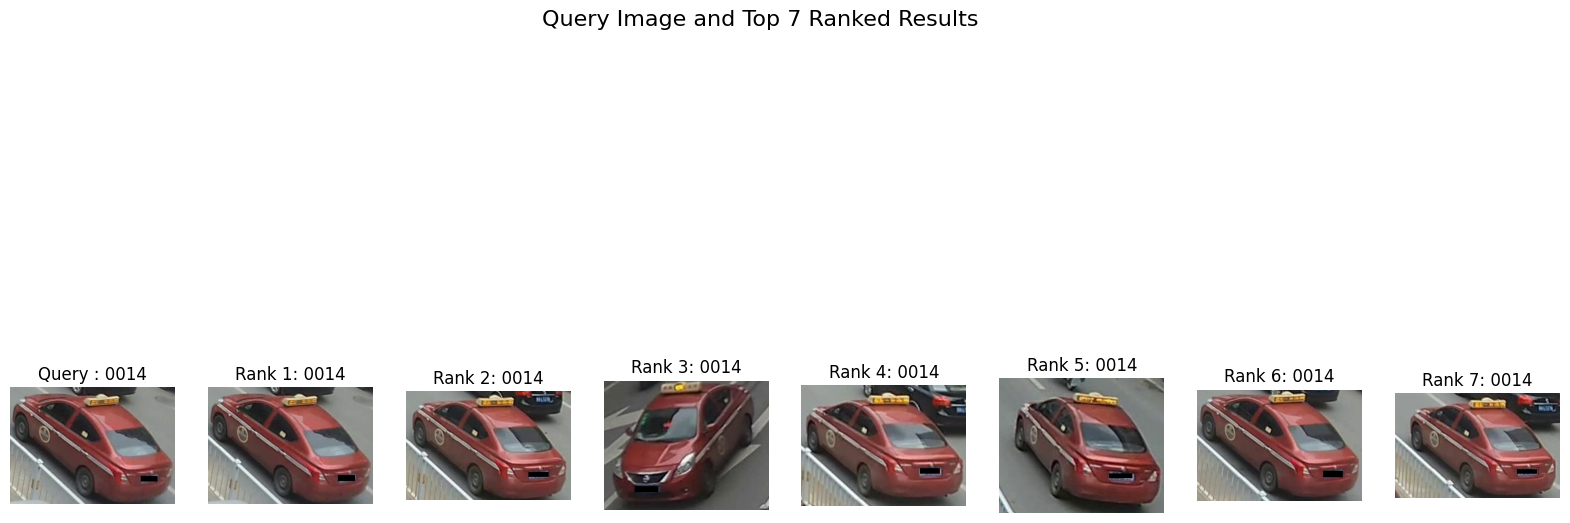

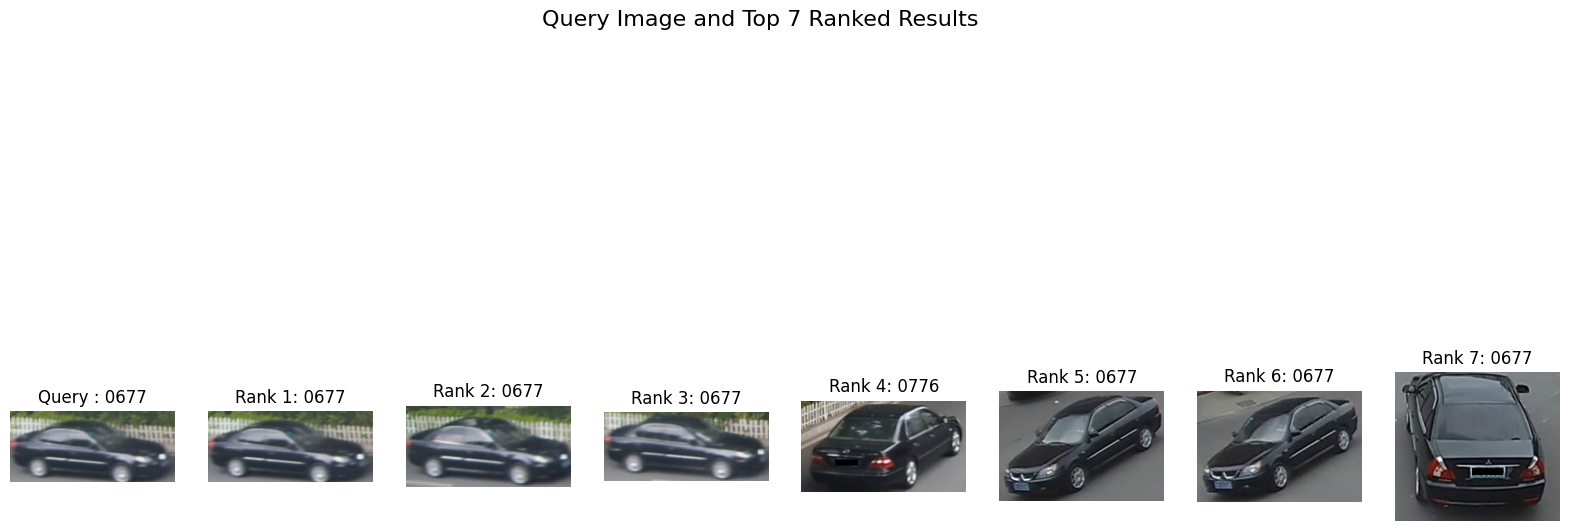

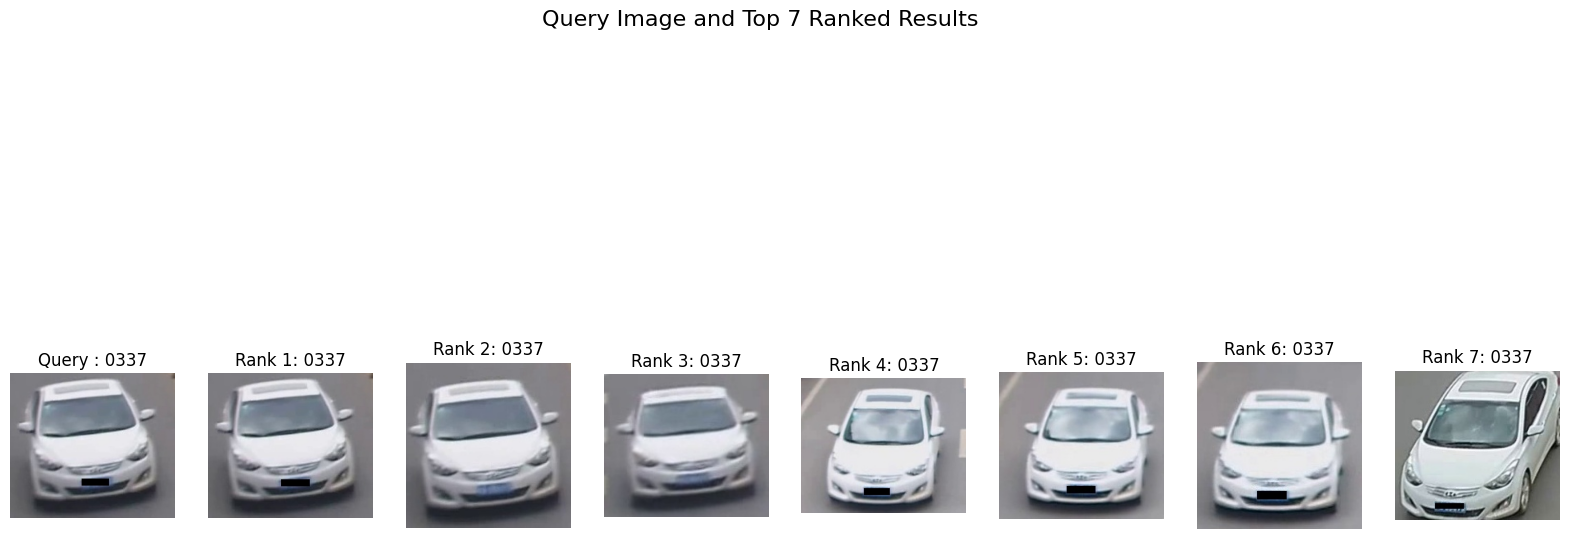

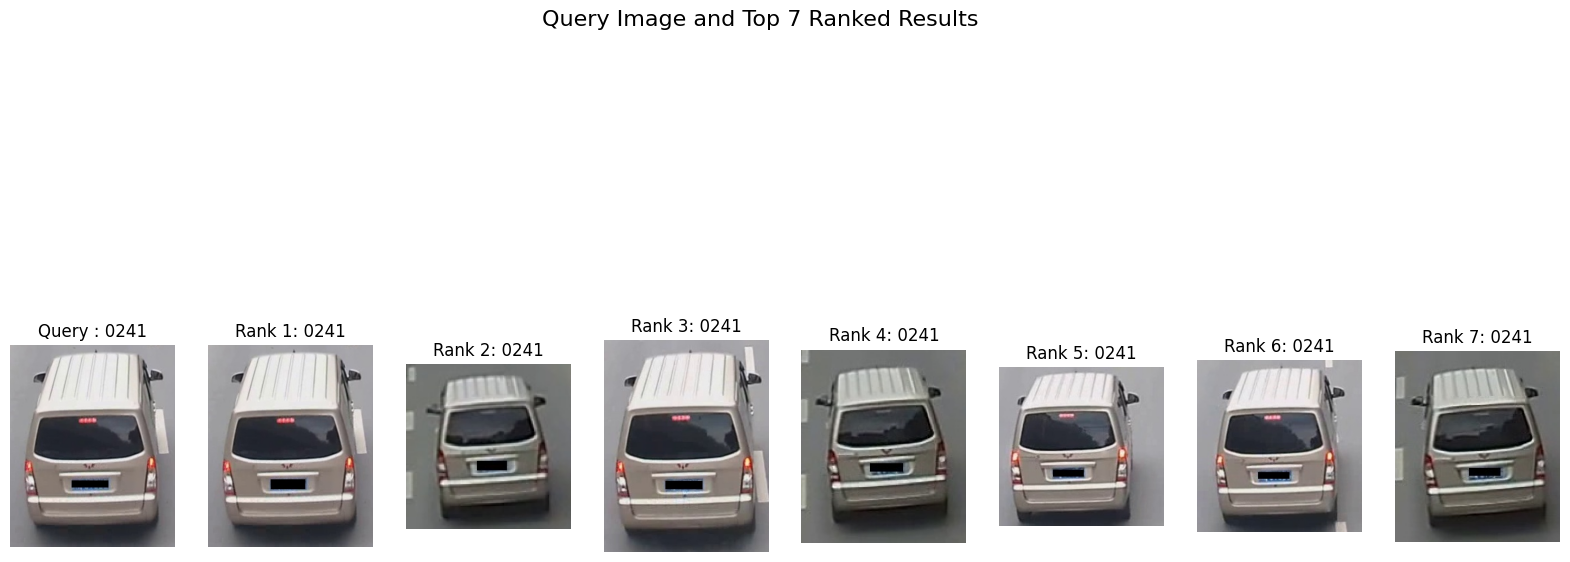

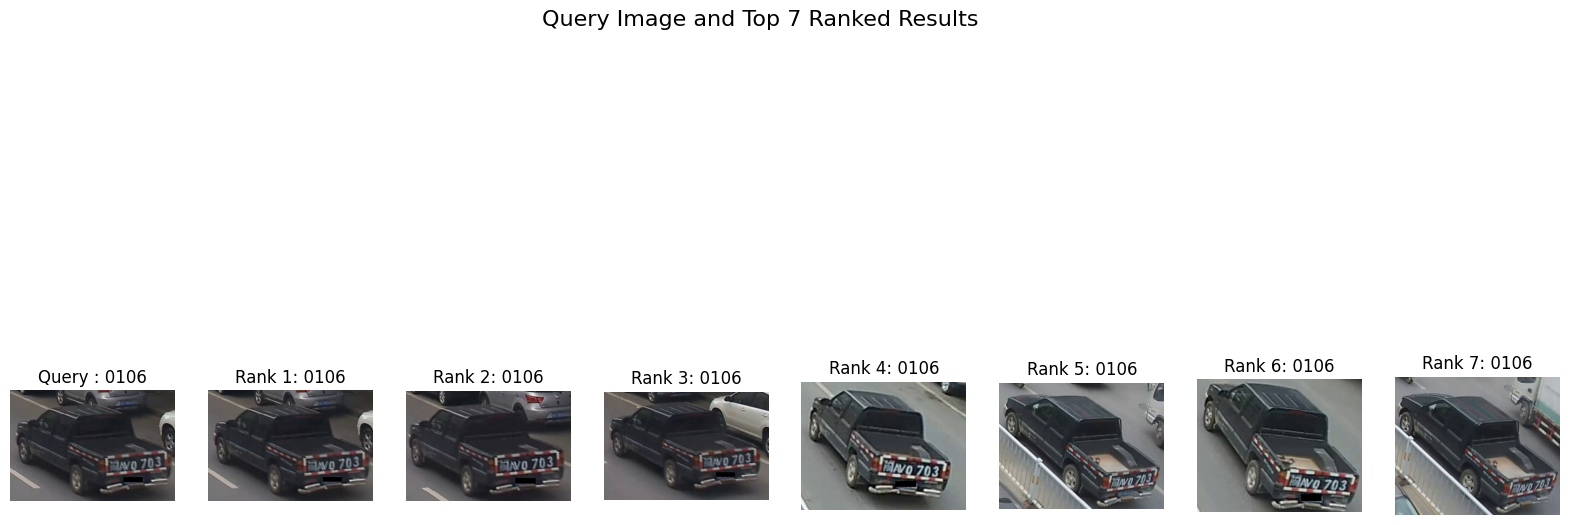

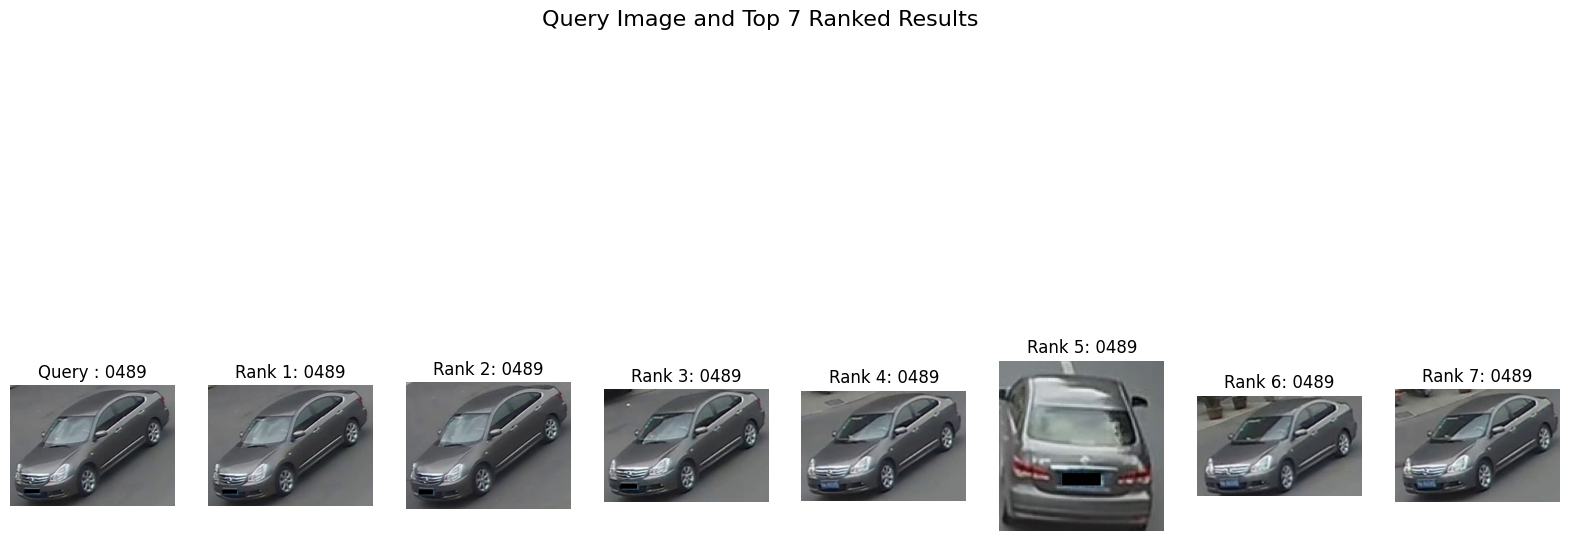

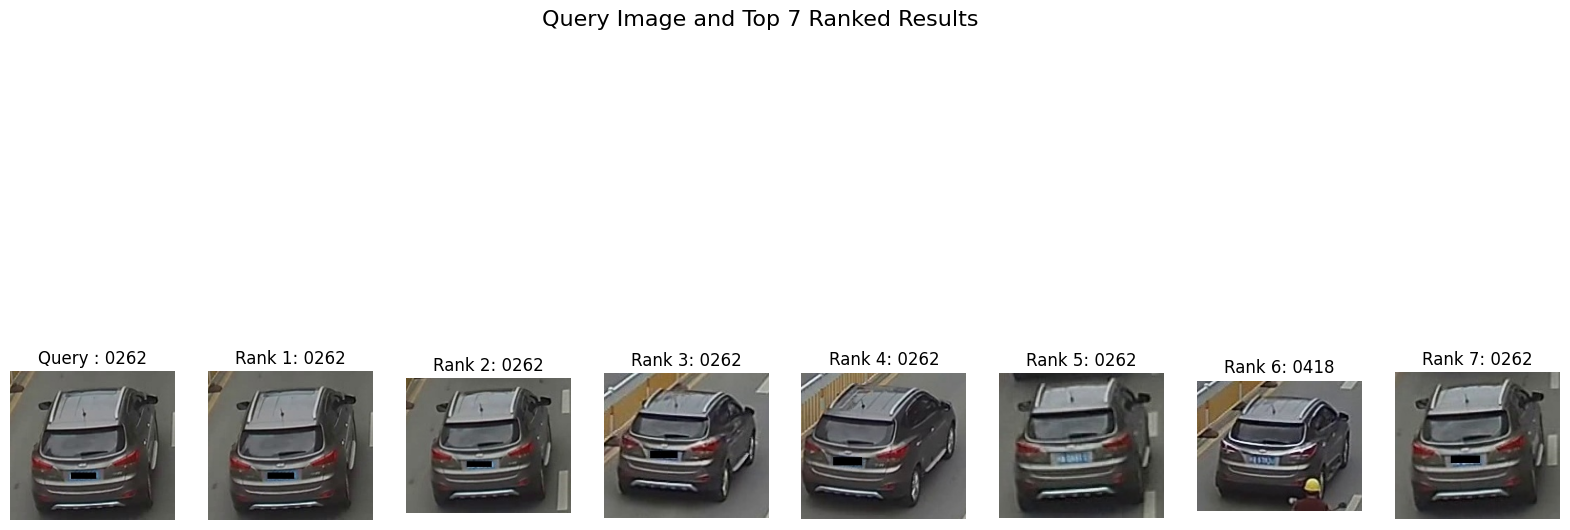

In [ ]:
#  Now the Qualitative evaluation,
visualize(query_index=1, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)
visualize(query_index=145, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)
visualize(query_index=528, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)
visualize(query_index=700, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)
visualize(query_index=565, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)
visualize(query_index=123, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)
visualize(query_index=58, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)
visualize(query_index=70, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)
visualize(query_index=17, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)
visualize(query_index=45, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)
visualize(query_index=28, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)
visualize(query_index=788, rankings=rankings, query_names=query_names, test_annotations=test_annotations, top_k=7)


In [ ]:
#  ALMOST PERFECT RESULTS, THIS IS BY FAR THE BEST PERFORMING MODEL

In [ ]:
# Calculate mean Average Precision (mAP) for all the query images
average_precisions = []
for i in range(len(query_labels)):
    ranked_labels = test_labels[rankings[i]]
    ap = compute_average_precision(query_labels[i], ranked_labels)
    average_precisions.append(ap)
mean_average_precision = np.mean(average_precisions)
print(f'Mean Average Precision (mAP): {mean_average_precision:.4f}')


Mean Average Precision (mAP): 0.5414




> #### <font color = blue size = 3> Comment </font>



**As the semi hard mining strategy already seemed to worked better than the random one, it also better to increase batch size and let the model learn from more informative triplets. this model is by far the best performig model, with a mAP of 0.36**